## Constructing a Generative Model 

In this notebook we will construct a simple generative model for an active inference agent navigating a 3x3 grid world environment. The agent can perform one of 5 actions at each time step: `LEFT, RIGHT, UP, DOWN, STAY`. The goal of the agent is to navigate to its preferred position. 

We will create matrices for both the environment as well as the agent itself. As we go up levels of abstraction, these environment and generative model matrices will be imported from classes - but this notebook is the lowest level representation of construction, to show how everything is built from the ground up.  


## Understanding the state space

The first thing to note is that we are in a 3x3 grid world which means we have 9 states in total. We can define the following mapping to better understand the space:

In [38]:
state_mapping = {0: (0,0), 1: (1,0), 2: (1,0), 3: (0,1), 4: (1,1), 5:(2,1), 6: (0,2), 7:(1,2), 8:(2,2)}

And the following heatmap just represents how the coordinates map to the real grid space

<AxesSubplot:>

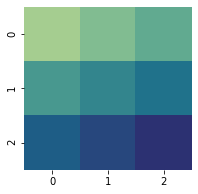

In [86]:
grid = np.zeros((3,3))
c = 1
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        grid[i,j] += c
        c += 1
fig = plt.figure(figsize = (3,3))
sns.heatmap(grid, cbar = False, cmap = 'crest')

## Likelihood Matrix: A

The likelihood matrix represents $P(o_t | s_t)$ , the probability of an observation given a state. In a grid world environment, the likelihood matrix of the agent is identical to that of the environment. It is simply the identity matrix over all states (in this case 9 states, for a 3x3 grid world) which represents the fact that the agent has probability 1 of observing that it is occupying any state x, given that it is in state x. This just means that the agent has full transparency over its own location in the grid. 

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
A = np.eye(9)

In [41]:
A

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

We can also plot the likelihood matrix as follows:

In [103]:
labels = [state_mapping[i] for i in range(A.shape[1])]
def plot_likelihood(A):
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(A, xticklabels = labels, yticklabels = labels, cbar = False)
    plt.title("Likelihood distribution (A)")
    plt.show()


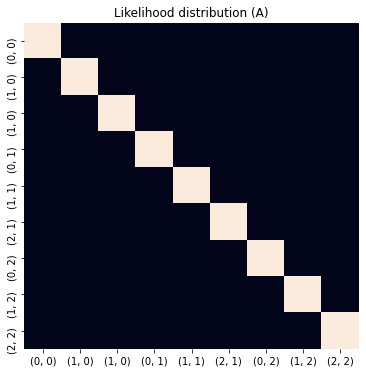

In [104]:
plot_likelihood(A)

## Transition matrix: B

The transition matrix determines how the agent can move around the gridworld given each of the 5 availabel actions (UP, DOWN, LEFT, RIGHT, STAY). 
So the transition matrix will be a 9x9x5 matrix, where each entry corresponds to a starting state, an end state, and the action that defines that specific transition. 

To construct this matrix, we have to understand that when the agent is at the edges of the grid, it cannot move outward, so trying to move right at the right wall will cause the agent to stay still. 

We will start by constructing a dictionary which we call P, which maps each state to its next state given an action

In [59]:
state_mapping

{0: (0, 0),
 1: (1, 0),
 2: (1, 0),
 3: (0, 1),
 4: (1, 1),
 5: (2, 1),
 6: (0, 2),
 7: (1, 2),
 8: (2, 2)}

In [95]:
P = {}
dim = 3
actions = {'UP':0, 'RIGHT':1, 'DOWN':2, 'LEFT':3, 'STAY':4}
for s in state_mapping.keys():
    P[s] = {a : [] for a in range(len(actions))}
    x, y = state_mapping[s][0], state_mapping[s][1]

    P[s][actions['UP']] = s if y == 0 else s - dim
    P[s][actions["RIGHT"]] = s if x == (dim -1) else s+1
    P[s][actions['DOWN']] = s if y == (dim -1) else s + dim 
    P[s][actions['LEFT']] = s if x == 0 else s -1 
    P[s][actions['STAY']] = s 

In [96]:
P

{0: {0: 0, 1: 1, 2: 3, 3: 0, 4: 0},
 1: {0: 1, 1: 2, 2: 4, 3: 0, 4: 1},
 2: {0: 2, 1: 3, 2: 5, 3: 1, 4: 2},
 3: {0: 0, 1: 4, 2: 6, 3: 3, 4: 3},
 4: {0: 1, 1: 5, 2: 7, 3: 3, 4: 4},
 5: {0: 2, 1: 5, 2: 8, 3: 4, 4: 5},
 6: {0: 3, 1: 7, 2: 6, 3: 6, 4: 6},
 7: {0: 4, 1: 8, 2: 7, 3: 6, 4: 7},
 8: {0: 5, 1: 8, 2: 8, 3: 7, 4: 8}}

From here, we can easily construct the transition matrix

In [98]:
num_states = 9
B = np.zeros([num_states, num_states, len(actions)])
for s in range(num_states):
    for a in range(len(actions)):
        ns = int(P[s][a])
        B[ns, s, a] = 1
        

B is a very large matrix, we can see its shape below, which is as expected:

In [100]:
B.shape

(9, 9, 5)

We can also visualize B on the plots below. The x axis is the starting state, and the y axis is the ending state, and each plot corresponds to an action given by the title.

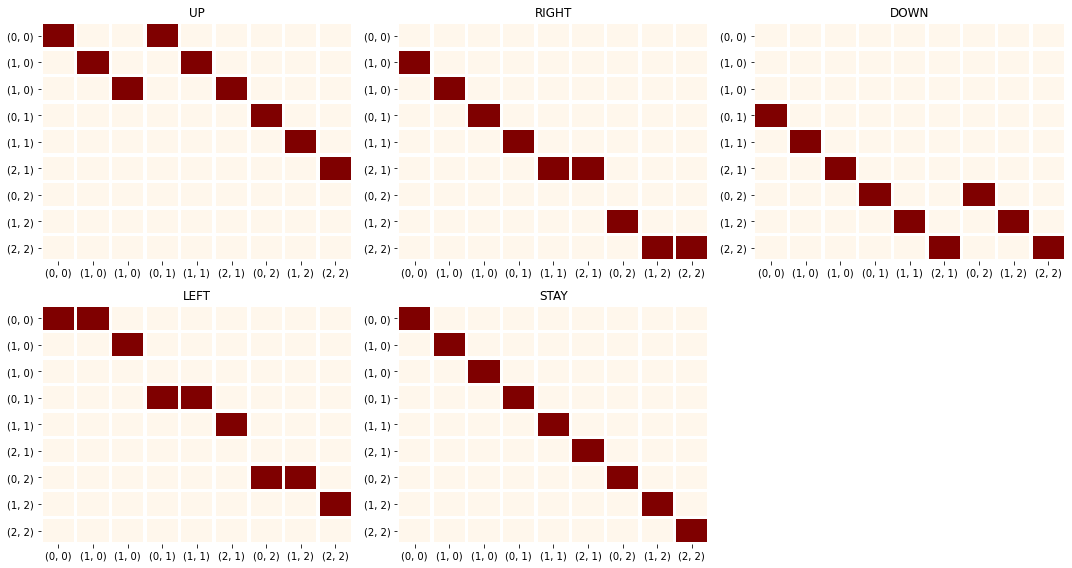

In [110]:
fig, axes = plt.subplots(2,3, figsize = (15,8))
a = list(actions.keys())
count = 0
for i in range(dim-1):
    for j in range(dim):
        if count >= 5:
            break 
        g = sns.heatmap(B[:,:,count], cmap = "OrRd", linewidth = 2.5, cbar = False, ax = axes[i,j], xticklabels=labels, yticklabels=labels)
        g.set_title(a[count])
        count +=1 
fig.delaxes(axes.flatten()[5])
plt.tight_layout()
plt.show()
    

## Preferences: C 

Now we have to encode the agent's preferences, so that it can learn to go to its reward state. In the current context, the agent wants (i.e. expects) to be in the reward location 7.

In [111]:
REWARD_LOCATION = 7
reward_state = state_mapping[REWARD_LOCATION]
print(reward_state)

(1, 2)


The C matrix is a 1x9 matrix, where each value represents the preference to occupy a given state. We will create a one-hot C matrix, so that the agent only has a preference to be in state 7. 

In [116]:
C = np.zeros(num_states)
C[REWARD_LOCATION] = 1. 
print(C)


[0. 0. 0. 0. 0. 0. 0. 1. 0.]


Now our generative model and environment are set up, and we can move on to Notebook 2, where we will run inference on the agent and see if it can reach the reward state.